Missing values in each column:
Patient_ID                                 0
Hypersplenism_Diagnosis                    0
Gender_Male                                0
Ethnicity_Asian                            0
Ethnicity_Caucasian                        0
Ethnicity_Hispanic                         0
Ethnicity_Other                            0
Smoking_Status_Former_Smoker               0
Smoking_Status_Non_Smoker                  0
Alcohol_Use_Occasional                     0
Alcohol_Use_Regular                        0
Liver_Disease_Fatty_Liver                  0
Liver_Disease_Hepatitis                    0
Liver_Disease_No_Liver_Disease             0
Blood_Disorder_Leukemia                    0
Blood_Disorder_Lymphoma                    0
Blood_Disorder_No_Blood_Disorder           0
Infections_Malaria                         0
Infections_No_Infection                    0
Infections_Tuberculosis                    0
Autoimmune_Disease_No_Autoimmune           0
Autoimmune_Disease_Rheum

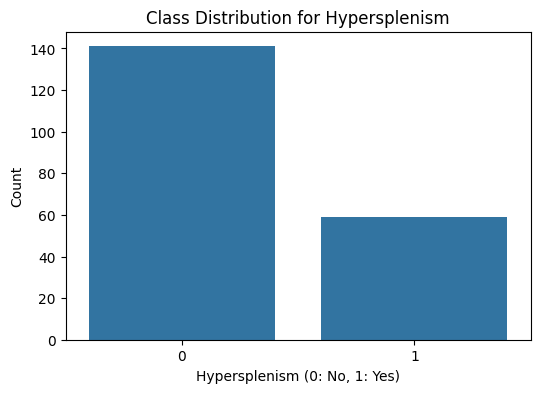

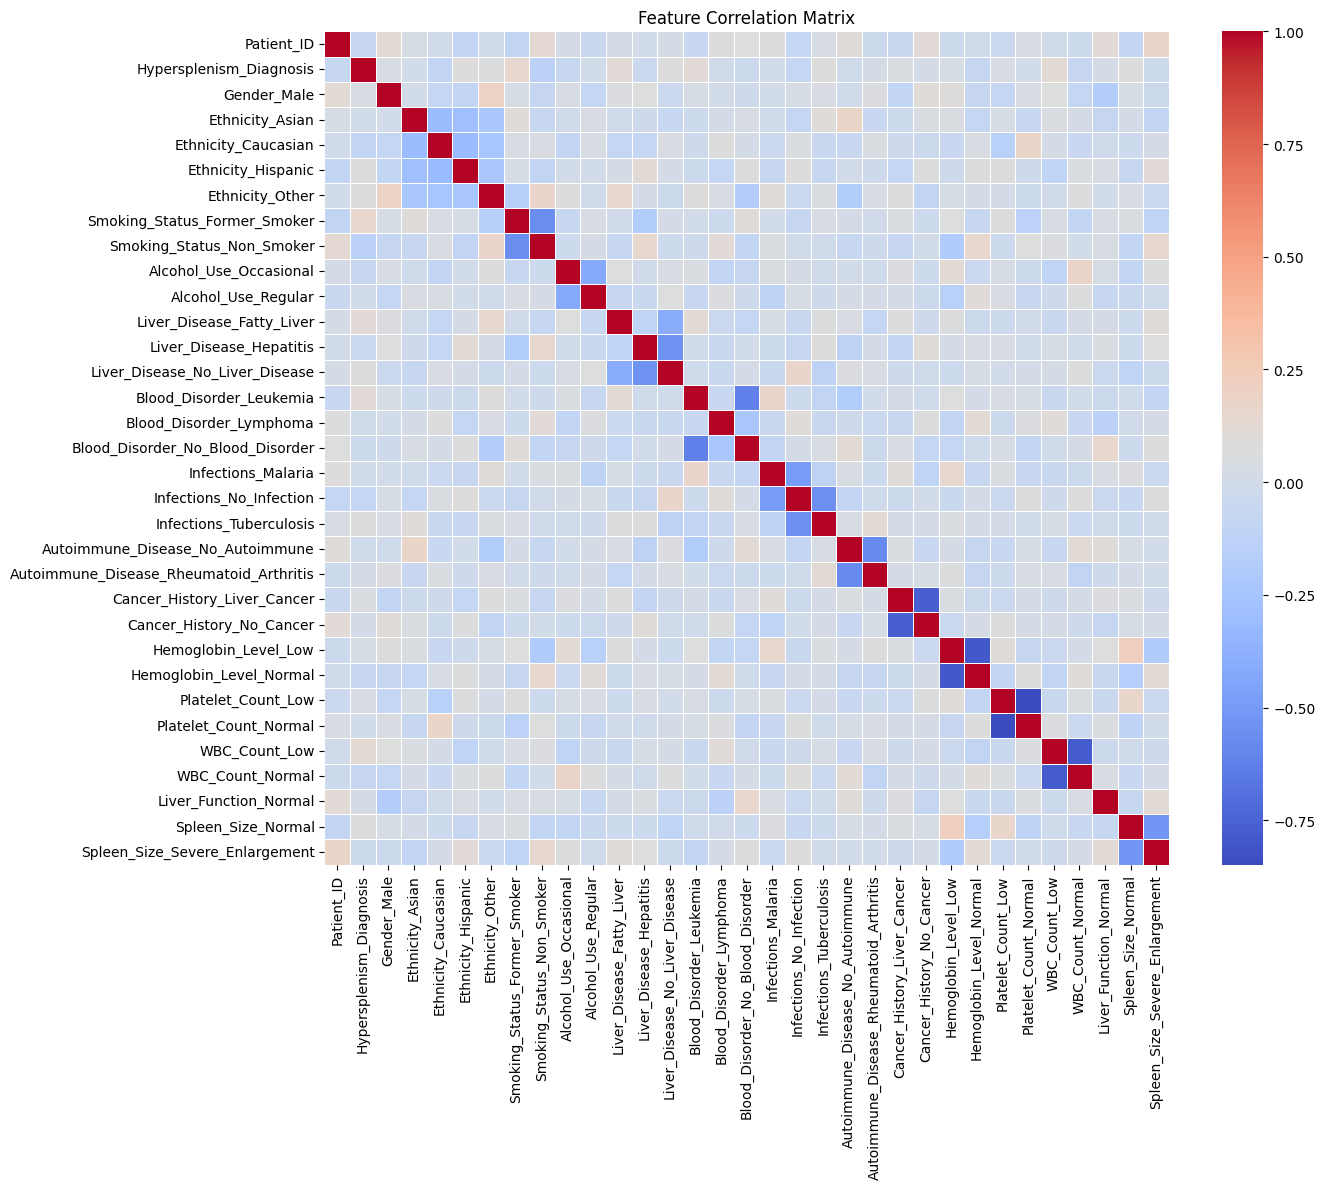


Top 10 features correlated with Hypersplenism:
Smoking_Status_Former_Smoker      0.153260
Smoking_Status_Non_Smoker         0.138712
WBC_Count_Low                     0.124092
Blood_Disorder_Leukemia           0.108562
Liver_Disease_Fatty_Liver         0.107187
Ethnicity_Caucasian               0.101750
Ethnicity_Hispanic                0.089361
Infections_Tuberculosis           0.087023
Liver_Disease_No_Liver_Disease    0.080910
Infections_No_Infection           0.080604
Name: Hypersplenism_Diagnosis, dtype: float64

Class distribution after SMOTE:
Hypersplenism_Diagnosis
0    50.0
1    50.0
Name: proportion, dtype: float64

Selected features:
['Patient_ID', 'Gender_Male', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Smoking_Status_Non_Smoker', 'Liver_Disease_Hepatitis', 'Infections_No_Infection', 'Hemoglobin_Level_Low', 'Hemoglobin_Level_Normal', 'Platelet_Count_Normal', 'WBC_Count_Normal', 'Spleen_Size_Severe_Enlargement']

Logistic Regression Results:
Cross Validation ROC-AUC: 0.809

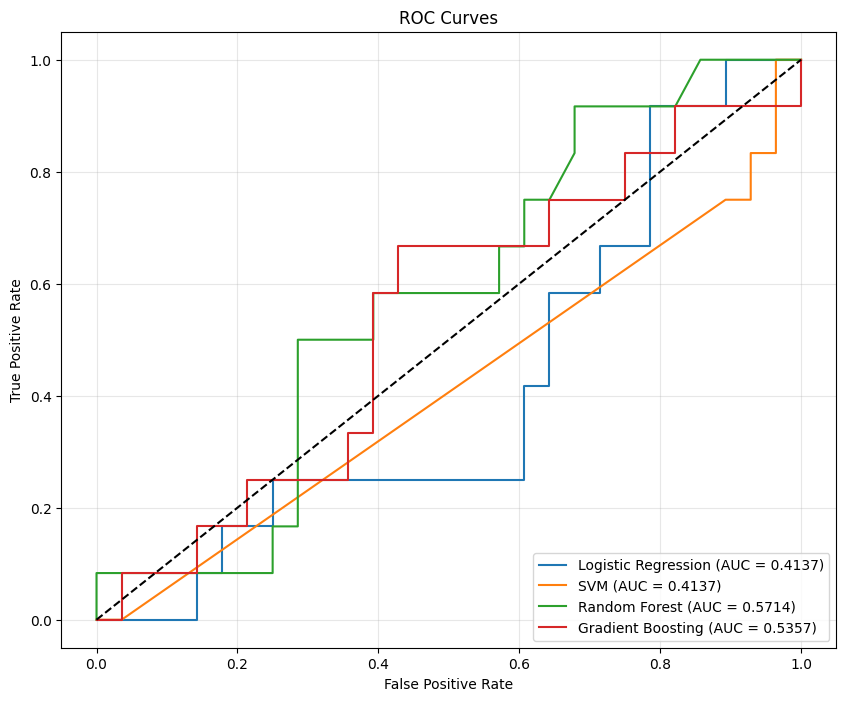


Best performing model: Random Forest


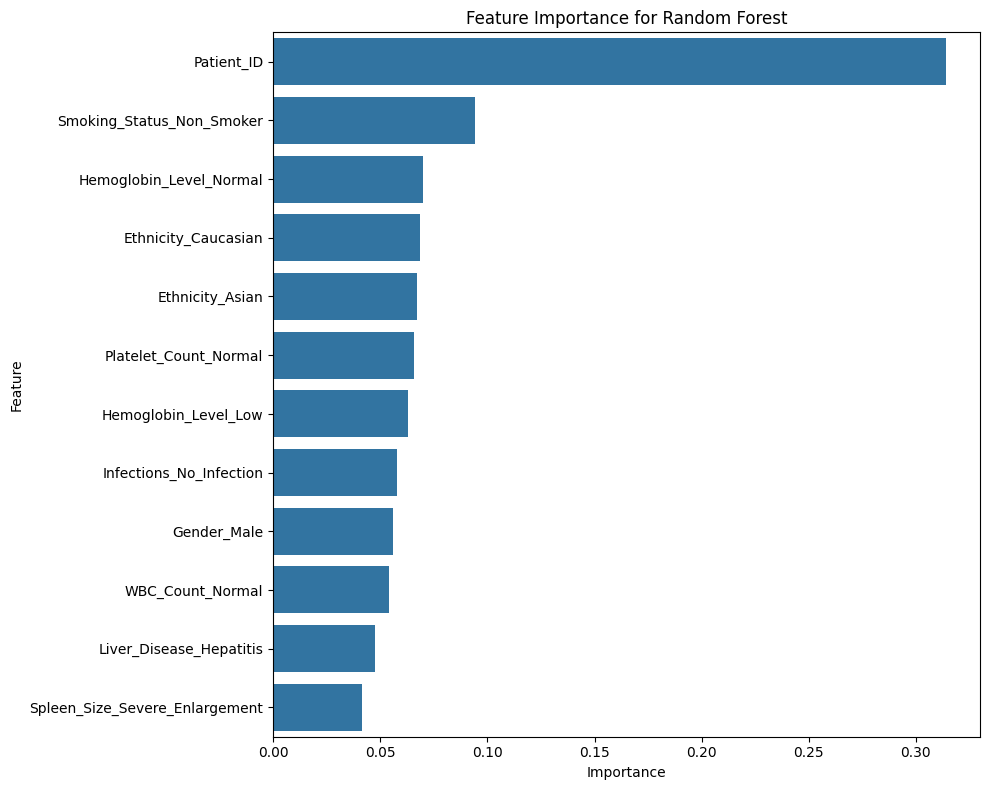


Top 10 most important features:
                      Feature  Importance
0                  Patient_ID    0.314206
4   Smoking_Status_Non_Smoker    0.094192
8     Hemoglobin_Level_Normal    0.070033
3         Ethnicity_Caucasian    0.068674
2             Ethnicity_Asian    0.067026
9       Platelet_Count_Normal    0.065948
7        Hemoglobin_Level_Low    0.063023
6     Infections_No_Infection    0.057812
1                 Gender_Male    0.056113
10           WBC_Count_Normal    0.053911


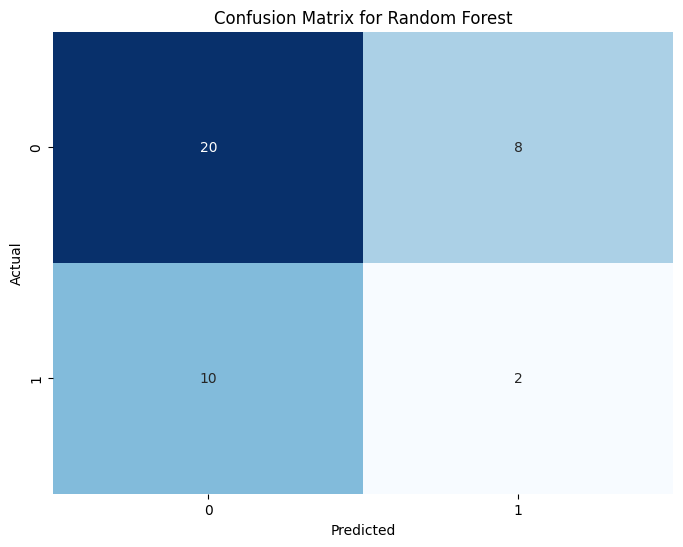


Example Patient Prediction:
Prediction: Hypersplenism
Probability: 0.5400
Risk Level: Medium

Model and selector saved to 'hypersplenism_model.pkl' and 'hypersplenism_selector.pkl'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

# Load the dataset from CSV file
# Replace 'your_data_file.csv' with the actual file path
df = pd.read_csv('preprocessed_hypersplenism_dataset.csv')

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Handle missing values if any
# df = df.dropna()  # Option 1: Drop rows with missing values
# df = df.fillna(df.mean())  # Option 2: Fill numeric columns with mean values

# Exploratory Data Analysis (EDA)
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df["Hypersplenism_Diagnosis"].value_counts(normalize=True) * 100)

# Check for class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='Hypersplenism_Diagnosis', data=df)
plt.title('Class Distribution for Hypersplenism')
plt.xlabel('Hypersplenism (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# Feature correlation analysis
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify top features correlated with the target
corr_with_target = correlation_matrix['Hypersplenism_Diagnosis'].abs().sort_values(ascending=False)
print("\nTop 10 features correlated with Hypersplenism:")
print(corr_with_target[1:11])  # Excluding the target itself

# Split the data
X = df.drop('Hypersplenism_Diagnosis', axis=1)
y = df['Hypersplenism_Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True) * 100)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(X_train_resampled, y_train_resampled)
selected_features = X_train.columns[selector.get_support()]

print("\nSelected features:")
print(selected_features.tolist())

X_train_selected = selector.transform(X_train_resampled)
X_test_selected = selector.transform(X_test)

# Train and evaluate multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_selected, y_train_resampled, cv=5, scoring='roc_auc')

    # Train the model
    model.fit(X_train_selected, y_train_resampled)

    # Predict on test set
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Store results
    results[name] = {
        'cv_scores': cv_scores,
        'accuracy': accuracy,
        'report': report,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'model': model
    }

    print(f"\n{name} Results:")
    print(f"Cross Validation ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    print(f"Precision (Class 1): {report['1']['precision']:.4f}")
    print(f"Recall (Class 1): {report['1']['recall']:.4f}")
    print(f"F1-Score (Class 1): {report['1']['f1-score']:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Identify best model (based on test ROC-AUC)
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = results[best_model_name]['model']
print(f"\nBest performing model: {best_model_name}")

# Feature importance analysis (if applicable)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance for {best_model_name}')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 most important features:")
    print(feature_importance.head(10))

# Confusion Matrix for best model
cm = confusion_matrix(y_test, best_model.predict(X_test_selected))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Function to predict hypersplenism for new patients
def predict_hypersplenism(patient_data, model=best_model, selector=selector):
    """
    Predict hypersplenism for a new patient.

    Parameters:
    patient_data (dict): Dictionary containing patient features
    model: Trained classification model
    selector: Feature selector used during training

    Returns:
    dict: Prediction results with probability
    """
    # Convert patient data to DataFrame
    patient_df = pd.DataFrame([patient_data])

    # Feature selection
    patient_features_selected = selector.transform(patient_df)

    # Predict
    prediction = model.predict(patient_features_selected)[0]
    probability = model.predict_proba(patient_features_selected)[0][1]

    return {
        'prediction': int(prediction),
        'probability': float(probability),
        'risk_level': 'High' if probability > 0.7 else 'Medium' if probability > 0.3 else 'Low'
    }

# Example of using the prediction function with data from the test set
# This assumes the first row of test data has the same features as your dataset
example_patient = X_test.iloc[0].to_dict()

# Get prediction for example patient
example_result = predict_hypersplenism(example_patient)
print("\nExample Patient Prediction:")
print(f"Prediction: {'Hypersplenism' if example_result['prediction'] == 1 else 'No Hypersplenism'}")
print(f"Probability: {example_result['probability']:.4f}")
print(f"Risk Level: {example_result['risk_level']}")

# Save model and selector for future use
import pickle

# Save best model
with open('hypersplenism_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save feature selector
with open('hypersplenism_selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

print("\nModel and selector saved to 'hypersplenism_model.pkl' and 'hypersplenism_selector.pkl'")

import pickle

# Assuming model is your trained model (like Logistic Regression, Random Forest, etc.)
# and selector is your feature selector (like SelectKBest or other transformers)

# Save the model
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the feature selector (if applicable)
with open('selector.pkl', 'wb') as selector_file:
    pickle.dump(selector, selector_file)